In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.regressor import generate_regressor_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["regressor"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['regressor']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-01 16:38:17.014086: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-01 16:38:17.391598: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-01 16:38:18.518736: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_052
rm: cannot remove '/kaggle/output/exp_052': No such file or directory


In [2]:
sub = pd.read_csv(f'/kaggle/output/{CFG["2nd_stage"]["execution"]["best_exp_id"]}/submission.csv')
oof = pd.read_csv(f'/kaggle/output/{CFG["2nd_stage"]["execution"]["best_exp_id"]}/oof.csv')
oof = oof.rename(columns={"oof": "oof_stage2"})
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
display(sub.head())
display(oof.head())
display(labels.head())

,series_id,key_step,event,score,step,minutes
0,038441c925bb,5025.0,onset,0.900691,5014,1725.0
1,038441c925bb,10913.0,wakeup,0.805931,10902,2365.0
2,038441c925bb,20389.0,onset,0.607547,20378,2945.0
3,038441c925bb,23793.0,wakeup,0.168968,23782,1965.0
4,038441c925bb,24046.0,onset,0.241711,24035,3230.0


,series_id,oof_1st,step,oof_stage2,minutes
0,038441c925bb,0.999825,11.0,0.999825,NaN
1,038441c925bb,0.999714,34.0,0.999714,NaN
2,038441c925bb,0.996018,57.0,0.996018,NaN
3,038441c925bb,0.996607,80.0,0.996607,NaN
4,038441c925bb,0.996458,103.0,0.996458,NaN


,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


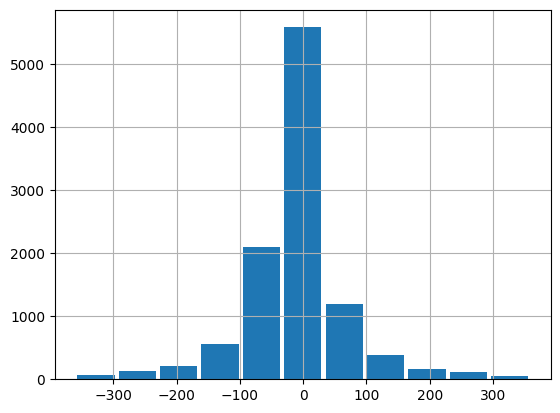

series_id     5563016
step          5563016
oof_stage2    5563016
minutes        906229
target          10566
sub_step        10566
key_step        10566
event           10566
score           10566
dtype: int64
82.61126981493118


,series_id,step,oof_stage2,minutes,target,sub_step,key_step,event,score
0,038441c925bb,11.0,0.999825,NaN,NaN,NaN,NaN,NaN,NaN
1,038441c925bb,34.0,0.999714,NaN,NaN,NaN,NaN,NaN,NaN
2,038441c925bb,57.0,0.996018,NaN,NaN,NaN,NaN,NaN,NaN
3,038441c925bb,80.0,0.996607,NaN,NaN,NaN,NaN,NaN,NaN
4,038441c925bb,103.0,0.996458,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# 正解ラベルを作成
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    targets = np.empty(len(sub_df))
    for i, sub_step in enumerate(sub_df["step"].values):
        best_step = np.inf
        for step in label_df["step"].values:
            if abs(step - sub_step) < abs(best_step - sub_step):
                best_step = step
        target = best_step - sub_step
        if abs(target) > 360:
            target = 0
        targets[i] = target
    sub_df["target"] = targets
    sub_df["sub_step"] = sub_df["step"].values
    dfs.append(sub_df)
sub = pd.concat(dfs).reset_index(drop=True)
plt.hist(sub["target"].values, bins=11, rwidth=0.9)
plt.grid()
plt.show()

train = oof[["series_id", "step", "oof_stage2", "minutes"]].merge(
    sub[["target", "series_id", "sub_step", "key_step", "event", "score"]], 
    left_on=["series_id", "step"], 
    right_on=["series_id", "key_step"], 
    how="left",
    )
print((~train.isna()).sum())
print((train.target ** 2).mean() ** 0.5)
display(train.head())

In [4]:
# 特徴生成
train, features = generate_regressor_features(train)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

100%|██████████| 277/277 [03:26<00:00,  1.34it/s]


,series_id,step,oof_stage2,minutes,target,sub_step,key_step,event,score,for_pred,...,for_pred_rolling_min_50_shift_100_diff,oof_stage2_rolling_median_50_shift_100_diff,oof_stage2_diff_abs_rolling_median_50_shift_100_diff,oof_stage2_mean_rolling_median_50_shift_100_diff,for_pred_rolling_median_50_shift_100_diff,oof_stage2_rolling_square_mean_50_shift_100_diff,oof_stage2_diff_abs_rolling_square_mean_50_shift_100_diff,oof_stage2_mean_rolling_square_mean_50_shift_100_diff,for_pred_rolling_square_mean_50_shift_100_diff,fold
0,038441c925bb,5025.0,0.116259,1725.0,-22.0,5014.0,5025.0,onset,0.900691,1.0,...,0.0,0.953288,-0.002326,0.953288,0.0,0.995514,-0.000049,0.995514,0.0,2
1,038441c925bb,10913.0,0.176107,2365.0,30.0,10902.0,10913.0,wakeup,0.805931,1.0,...,0.0,-0.948660,0.006441,-0.948660,0.0,-0.992845,0.000221,-0.992845,0.0,2
2,038441c925bb,20389.0,0.200483,2945.0,-134.0,20378.0,20389.0,onset,0.607547,1.0,...,0.0,0.895942,-0.016929,0.895942,0.0,0.982170,-0.001305,0.982170,0.0,2
3,038441c925bb,23793.0,0.643917,1965.0,0.0,23782.0,23793.0,wakeup,0.168968,1.0,...,0.0,0.117864,0.010972,0.117864,0.0,0.030123,0.000770,0.030123,0.0,2
4,038441c925bb,24046.0,0.628390,3230.0,0.0,24035.0,24046.0,onset,0.241711,1.0,...,0.0,0.125281,0.016655,0.125281,0.0,0.031897,0.001342,0.031897,0.0,2


(10566, 1385)

In [5]:
# 学習
trn_oof, models = fit_xgb(
    X=train, 
    y=train["target"], 
    folds=train["fold"].astype(int), 
    features=features.all_features(),
    params=CFG["regressor"]["xgboost"], 
    es_rounds=100,
)
train["oof_regressor"] = trn_oof
train["key_step"] = train["step"]
train["sub_step_before_modify"] = train["sub_step"]
train["step"] = (train["sub_step"] + train["oof_regressor"]).astype(int)
sub = train[[
    "step", "sub_step_before_modify", "key_step", 
    "series_id", "score", "event", 
    "oof_stage2", "oof_regressor", 
    "target", "minutes"]]

# 保存
for i, model in enumerate(models):
    model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))
with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:76.19132
[100]	eval-rmse:70.25194
[200]	eval-rmse:69.15959
[300]	eval-rmse:68.93951
[379]	eval-rmse:68.98238


 20%|██        | 1/5 [00:05<00:23,  5.78s/it]

== fold 1 ==
[0]	eval-rmse:85.78539
[100]	eval-rmse:79.22589
[200]	eval-rmse:77.47919
[300]	eval-rmse:77.01318
[400]	eval-rmse:76.84910
[500]	eval-rmse:76.80850
[600]	eval-rmse:76.77789
[700]	eval-rmse:76.79449
[733]	eval-rmse:76.78236


 40%|████      | 2/5 [00:14<00:23,  7.70s/it]

== fold 2 ==
[0]	eval-rmse:86.91771
[100]	eval-rmse:81.42379
[200]	eval-rmse:80.41398
[300]	eval-rmse:80.21217
[400]	eval-rmse:80.21698
[418]	eval-rmse:80.23739


 60%|██████    | 3/5 [00:20<00:13,  6.81s/it]

== fold 3 ==
[0]	eval-rmse:81.68702
[100]	eval-rmse:75.93352
[200]	eval-rmse:74.99542
[300]	eval-rmse:74.96213
[400]	eval-rmse:74.93892
[473]	eval-rmse:74.97041


 80%|████████  | 4/5 [00:26<00:06,  6.60s/it]

== fold 4 ==
[0]	eval-rmse:82.17735
[100]	eval-rmse:75.30307
[200]	eval-rmse:74.18514
[300]	eval-rmse:74.23118
[334]	eval-rmse:74.20839


100%|██████████| 5/5 [00:31<00:00,  6.29s/it]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)

score: 0.6698


event   tolerance
onset   12           0.106220
        36           0.438181
        60           0.584185
        90           0.685507
        120          0.745449
        150          0.776704
        180          0.801072
        240          0.822192
        300          0.838172
        360          0.851072
wakeup  12           0.124340
        36           0.438837
        60           0.584125
        90           0.681810
        120          0.743883
        150          0.780962
        180          0.807586
        240          0.840986
        300          0.864078
        360          0.880315
dtype: float64